# Synthetic Data Generation using VAE

Model Training:

Encoding: The VAE's encoder takes an input image (a handwritten digit from MNIST) and compresses it into a smaller, latent space representation. This representation consists of two parts: a mean (mu) and a log-variance (logvar).

Sampling: From these two parts, we sample a point in the latent space using a technique called the reparameterization trick. This trick ensures that we can backpropagate through the sampling step during training.

Decoding: The decoder takes the sampled point from the latent space and reconstructs the input image from it.

Loss Calculation: The loss function measures how well the reconstructed image matches the original image (reconstruction loss) and how close the latent space distribution is to a standard normal distribution (KL divergence loss). The model is trained to minimize this loss.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        #The encoder compresses input images to latent space representations (mean and log-variance).
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim * 2)  # For mean and log-variance
        )
        #The decoder reconstructs images from latent space points.
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [3]:
#Load and transform the MNIST dataset into a format suitable for the model.
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the 28x28 images to a 784 vector
])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
"""For each batch of images, the model:
Encodes the images to latent space.
Samples points from the latent space.
Decodes the points back to images.
Calculates the loss and updates the model parameters to minimize this loss. """

vae = VAE(input_dim=784, hidden_dim=400, latent_dim=20)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(torch.float32)  # Ensure data is of type float32
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')

    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

for epoch in range(1, 11):
    train(epoch)


Train Epoch: 1 [0/60000 (0%)]	Loss: 549.504028
Train Epoch: 1 [12800/60000 (21%)]	Loss: 176.151871
Train Epoch: 1 [25600/60000 (43%)]	Loss: 156.367447
Train Epoch: 1 [38400/60000 (64%)]	Loss: 145.198532
Train Epoch: 1 [51200/60000 (85%)]	Loss: 128.412842
====> Epoch: 1 Average loss: 164.4426
Train Epoch: 2 [0/60000 (0%)]	Loss: 129.292175
Train Epoch: 2 [12800/60000 (21%)]	Loss: 124.432259
Train Epoch: 2 [25600/60000 (43%)]	Loss: 129.053848
Train Epoch: 2 [38400/60000 (64%)]	Loss: 114.454315
Train Epoch: 2 [51200/60000 (85%)]	Loss: 115.475281
====> Epoch: 2 Average loss: 121.3960
Train Epoch: 3 [0/60000 (0%)]	Loss: 116.046104
Train Epoch: 3 [12800/60000 (21%)]	Loss: 110.964462
Train Epoch: 3 [25600/60000 (43%)]	Loss: 112.340424
Train Epoch: 3 [38400/60000 (64%)]	Loss: 114.786880
Train Epoch: 3 [51200/60000 (85%)]	Loss: 113.479576
====> Epoch: 3 Average loss: 114.5561
Train Epoch: 4 [0/60000 (0%)]	Loss: 114.617790
Train Epoch: 4 [12800/60000 (21%)]	Loss: 112.948723
Train Epoch: 4 [25600/

Generating Synthetic Data:

Sampling from Latent Space: After training, we can generate new data by sampling random points from the latent space.
Decoding to Generate New Images: These sampled points are passed through the decoder to generate new images. These images are synthetic, meaning they are new creations of the VAE and are not direct copies of any images in the training set

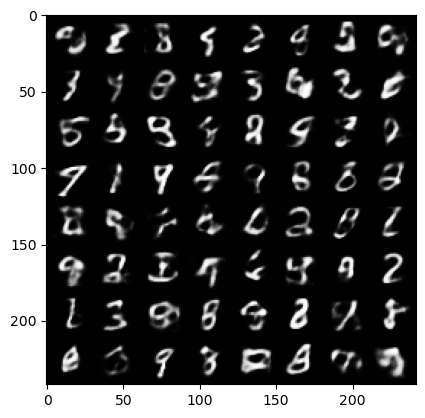

In [4]:
import matplotlib.pyplot as plt
import torchvision

"""Sample random points from a standard normal distribution 
(the latent space the model was trained to approximate).
"""
def generate_synthetic_data(num_samples, latent_dim):
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim)
        #Use the decoder to convert these latent points into new images.
        synthetic_data = vae.decode(z).cpu()
        return synthetic_data.view(num_samples, 1, 28, 28)

# Generate and visualize synthetic data
synthetic_data = generate_synthetic_data(64, 20)  # 64 samples, latent dimension 20
grid = torchvision.utils.make_grid(synthetic_data, nrow=8)
plt.imshow(grid.permute(1, 2, 0))
plt.show()


VAE learns to encode and decode images such that it can generate new images by sampling from the learned latent space. This process allows for the creation of synthetic data that mimics the properties of the original dataset.